   <h1 style="color:black;font-size:45px;background:gold;font-style:bold;font-family:geogia;border-radius:20px;">FISH LIFE   using a Deep Q Network (DQN) reinforcement learning<h1>

 <center style="font-family:open sans;"><h2 style="color:gold;background:black;font-size:50px;">  Work By:</h2><br><h3 style="background:black;font-size:45px;color:gold;">Muzamil Aslam Ganaiee<br></center>

 <center style="font-family:open sans;"><h3 style="background:green;font-size:45px;color:white;">importing libraries<br></center>

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import gym
from gym import spaces
from collections import deque
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import klib as kl


 <center style="font-family:open sans;"><h3 style="background:green;font-size:45px;color:white;">Load dataset <br>Perform data preprocessing and feature engineering...<br></center>

In [15]:

data = pd.read_csv('dataset.csv')
fish_conditions = [

    data['NITRATE(PPM)'] >= 100,
    (data['PH'] >= 4.8) & (data['PH'] <= 6.5),
    data['AMMONIA(mg/l)'] >= 0.05,
    (data['TEMP'] >= 12) & (data['TEMP'] <= 15),
    data['DO'] <= 3,
    data['TURBIDITY'] <= 12,
    data['MANGANESE(mg/l)'] <= 1.0
]

# Assign 1 if at least two conditions are met, 0 otherwise
data['FISH'] = (np.sum(fish_conditions, axis=0) >= 2).astype(int)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18102 entries, 0 to 18101
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Station          18102 non-null  object 
 1   Date             18102 non-null  object 
 2   NITRATE(PPM)     18076 non-null  float64
 3   PH               18066 non-null  float64
 4   AMMONIA(mg/l)    18072 non-null  float64
 5   TEMP             18061 non-null  float64
 6   DO               18076 non-null  float64
 7   TURBIDITY        18076 non-null  float64
 8   MANGANESE(mg/l)  18083 non-null  float64
 9   FISH             18102 non-null  int32  
dtypes: float64(7), int32(1), object(2)
memory usage: 1.3+ MB


<Axes: title={'center': 'Feature-correlation (pearson)'}>

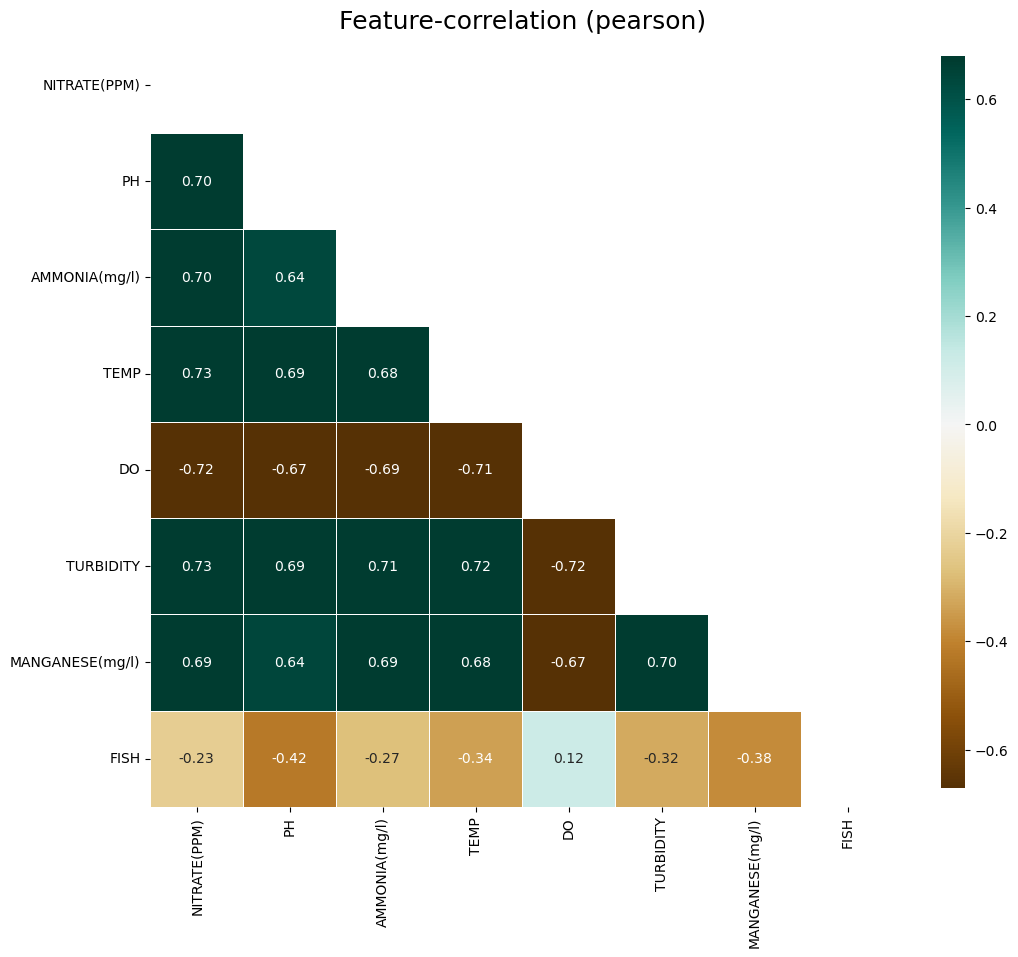

In [17]:
kl.corr_plot(data)

GridSpec(6, 2)

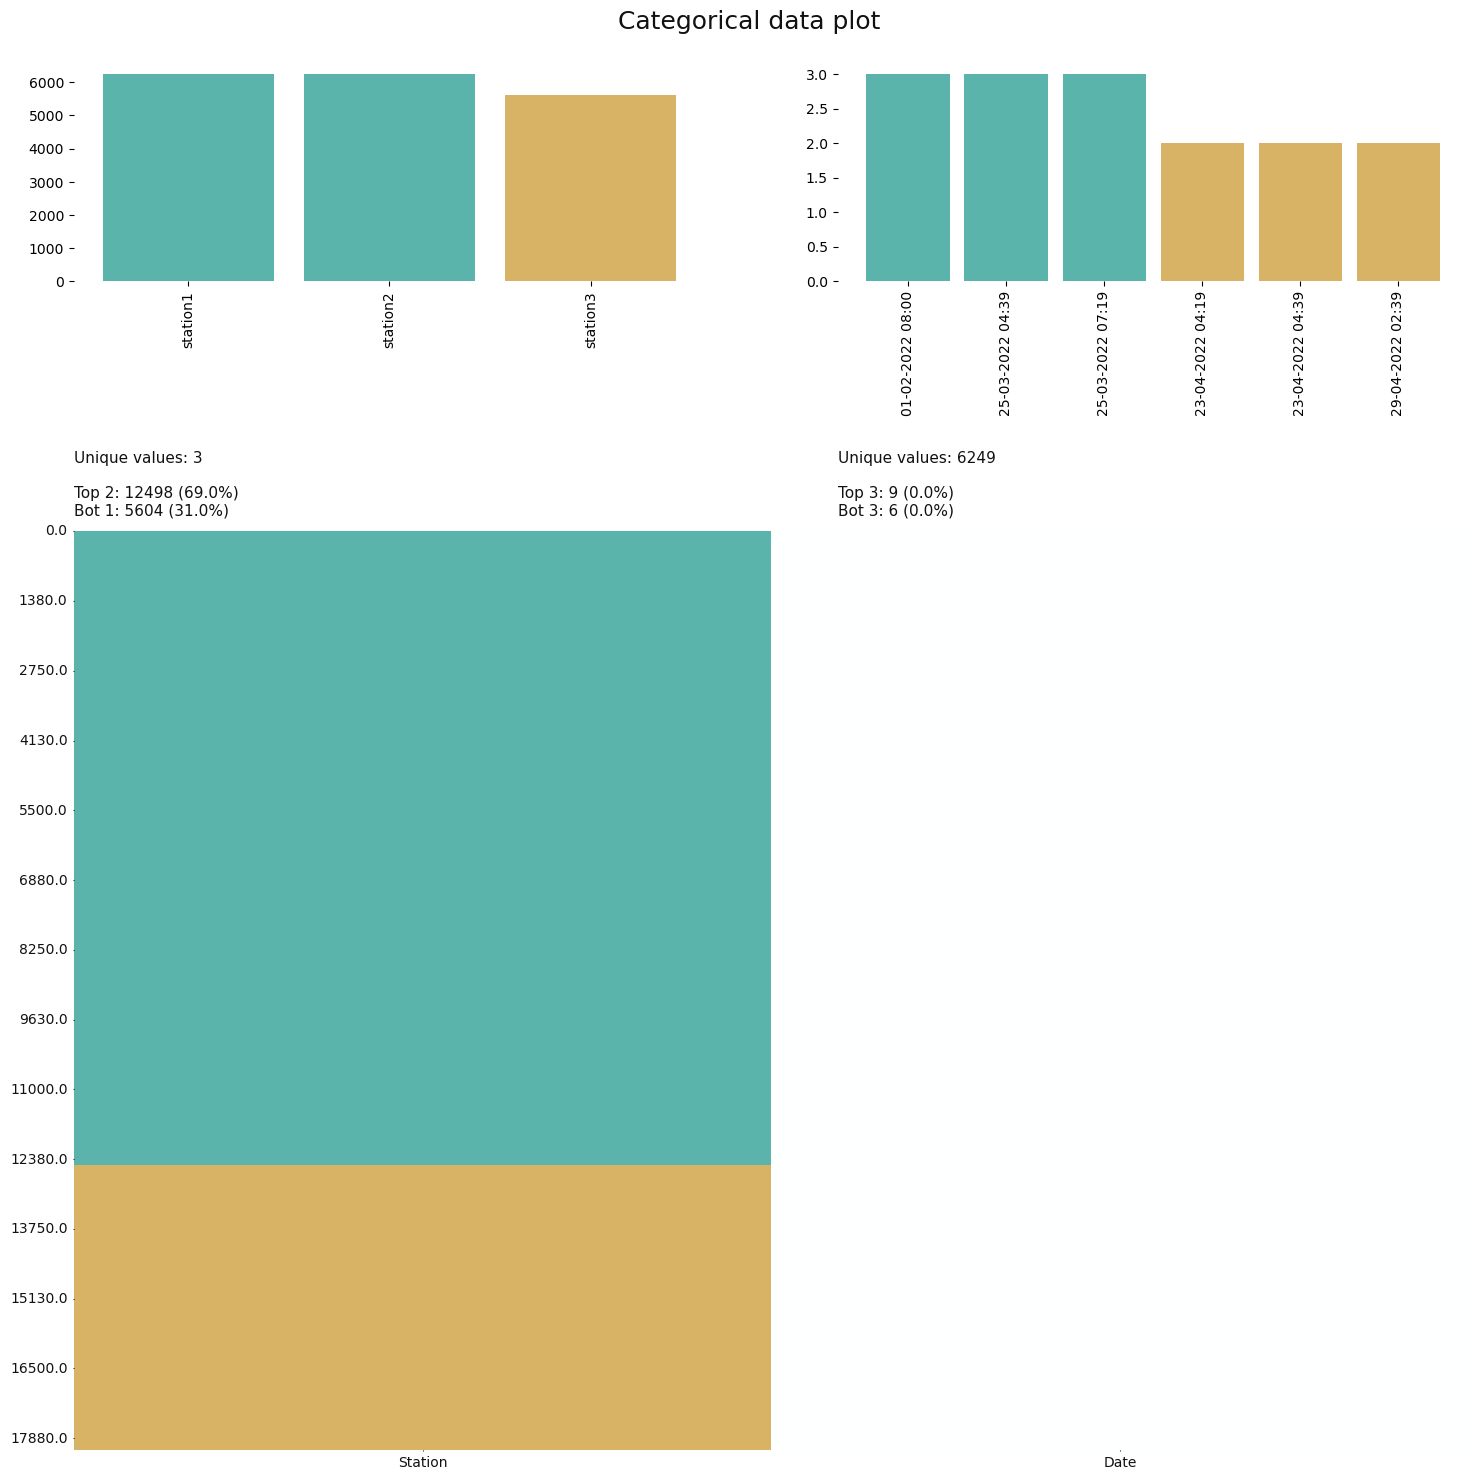

In [20]:
kl.cat_plot(data)

In [21]:
kl.corr_mat(data)

,NITRATE(PPM),PH,AMMONIA(mg/l),TEMP,DO,TURBIDITY,MANGANESE(mg/l),FISH
NITRATE(PPM),1.00,0.70,0.70,0.73,-0.72,0.73,0.69,-0.23
PH,0.70,1.00,0.64,0.69,-0.67,0.69,0.64,-0.42
AMMONIA(mg/l),0.70,0.64,1.00,0.68,-0.69,0.71,0.69,-0.27
TEMP,0.73,0.69,0.68,1.00,-0.71,0.72,0.68,-0.34
DO,-0.72,-0.67,-0.69,-0.71,1.00,-0.72,-0.67,0.12
TURBIDITY,0.73,0.69,0.71,0.72,-0.72,1.00,0.70,-0.32
MANGANESE(mg/l),0.69,0.64,0.69,0.68,-0.67,0.70,1.00,-0.38
FISH,-0.23,-0.42,-0.27,-0.34,0.12,-0.32,-0.38,1.00


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='NITRATE(PPM)', ylabel='Density'>

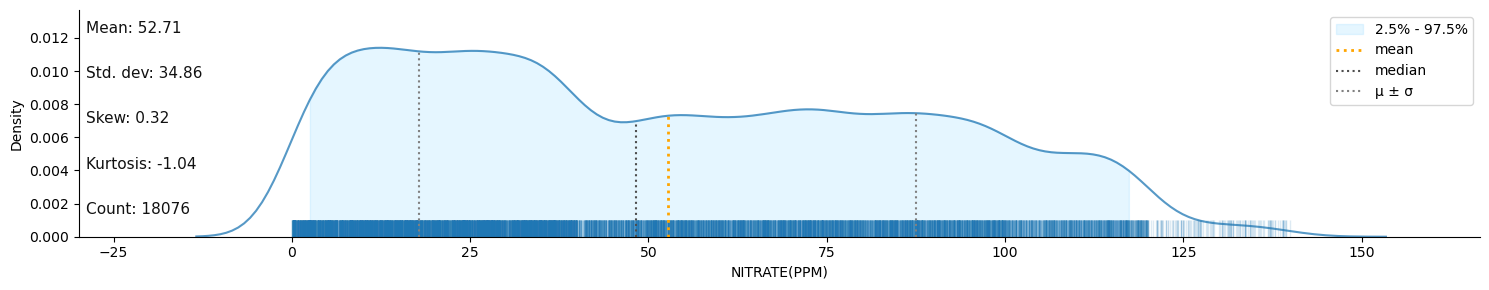

In [22]:
kl.dist_plot(data)

GridSpec(6, 6)

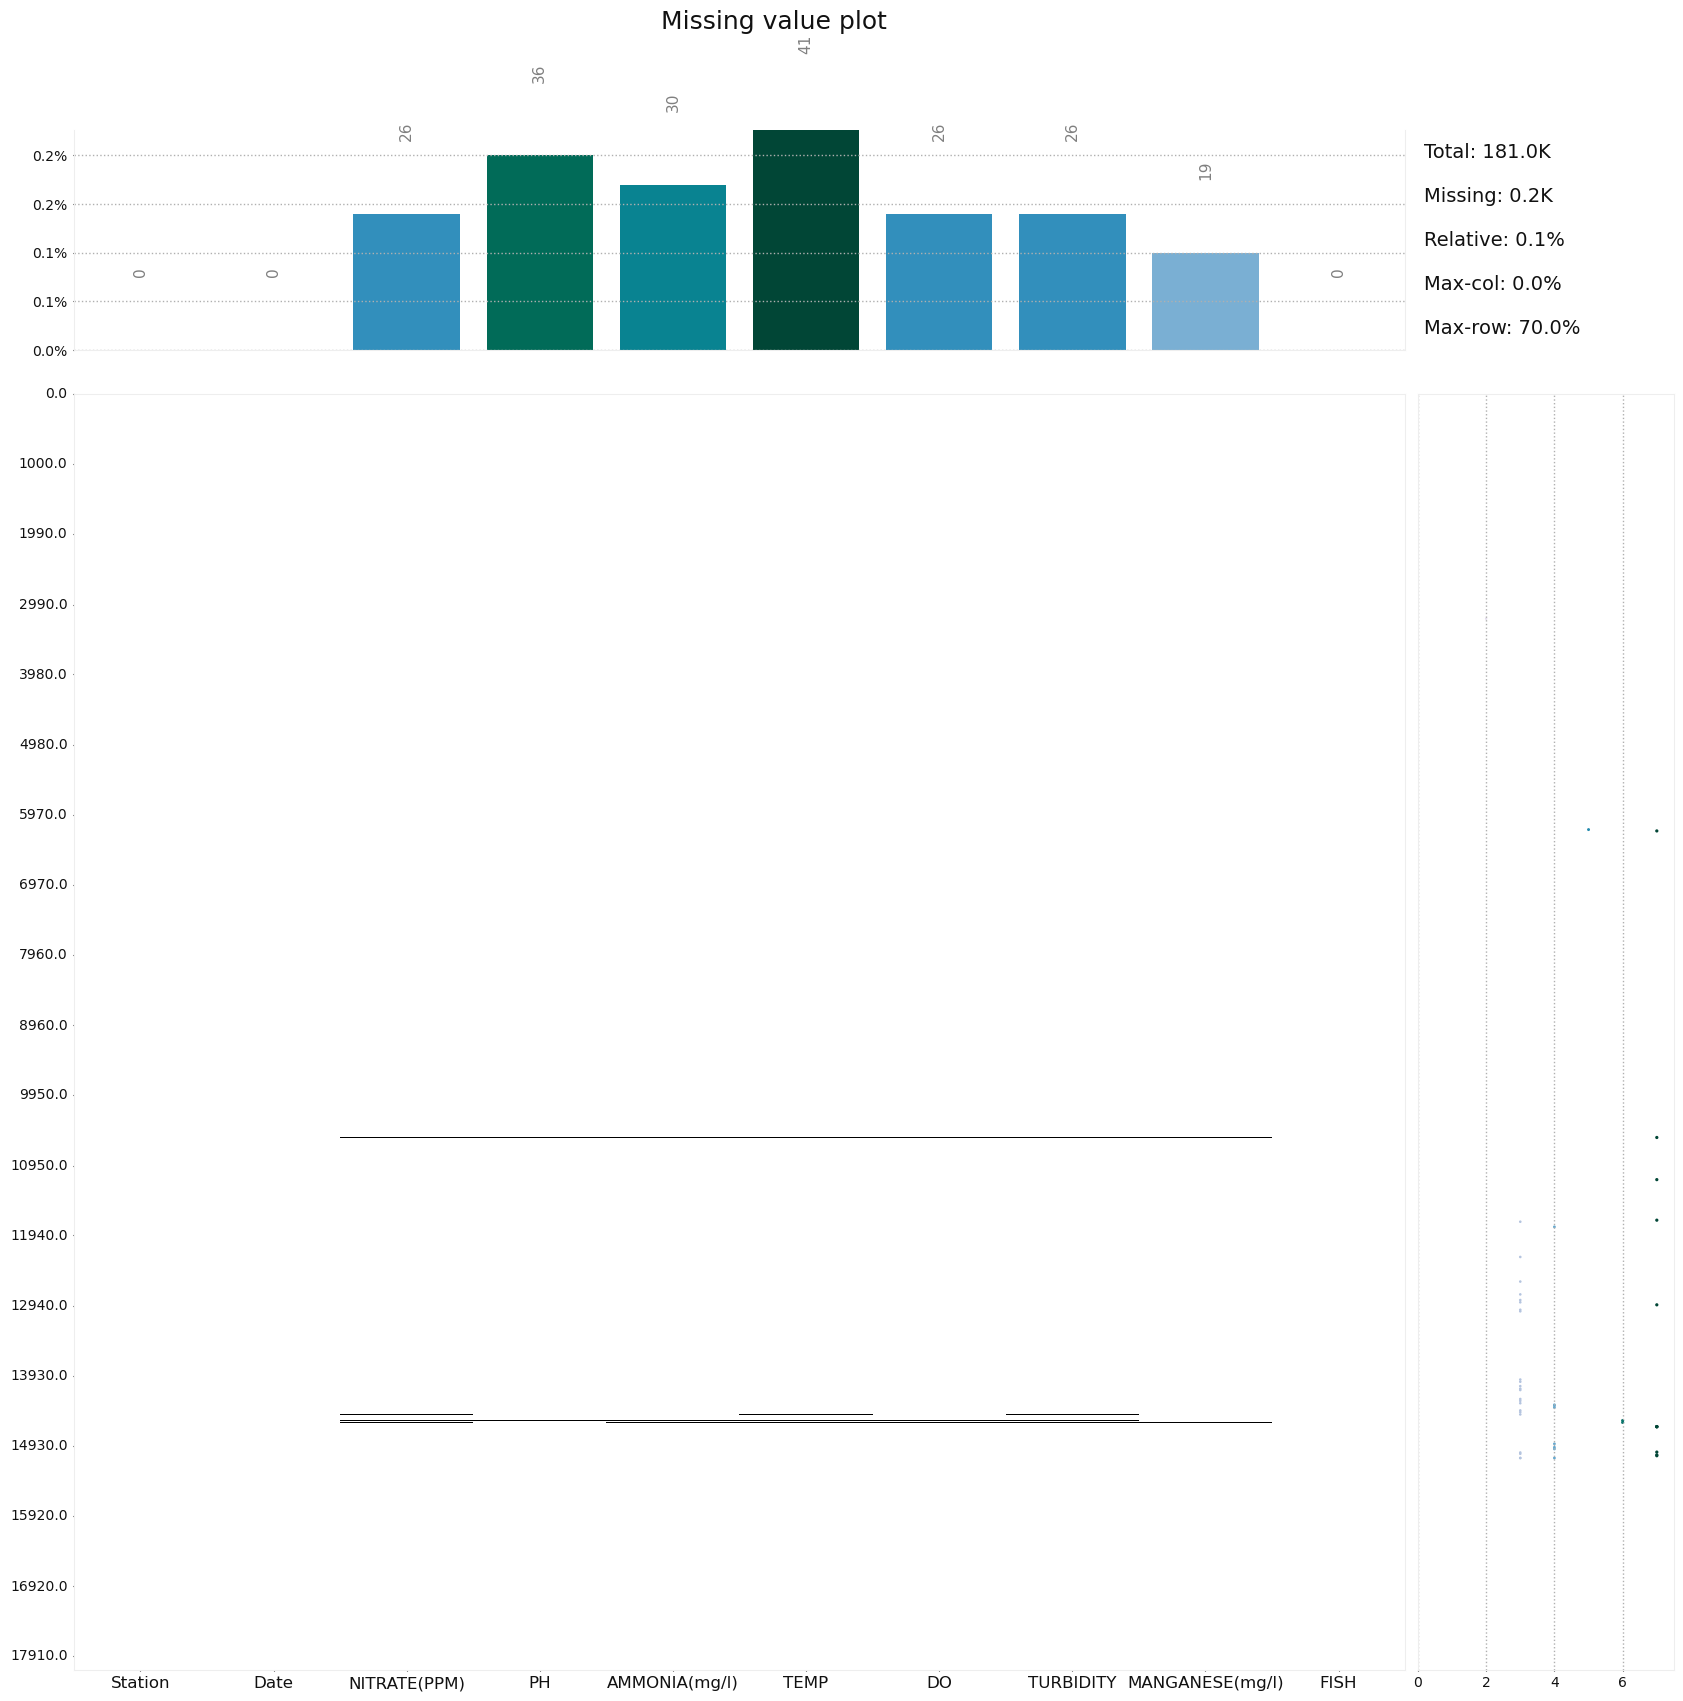

In [23]:
kl.missingval_plot(data) 

In [ ]:
# Separate features and labels
X = data.drop('FISH', axis=1)
y = data['FISH'].astype(int)


In [ ]:
# Encode categorical data in features
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

In [ ]:
# Normalize the feature data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [6]:
class ClassificationEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, data, labels):
        super(ClassificationEnv, self).__init__()
        self.data = data.values
        self.labels = labels.values
        self.current_step = 0
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(data.shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.data[self.current_step]

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        real_action = self.labels[self.current_step]
        reward = 1 if action == real_action else -1

        if not done:
            next_state = self.data[self.current_step]
        else:
            next_state = None

        return next_state, reward, done, {}

    def render(self, mode='console'):
        pass  # Add any rendering logic here if needed


In [ ]:
env = ClassificationEnv(X_train, y_train)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 32

n_episodes = 1000

for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"Episode: {e}/{n_episodes}, Score: {time}, Epsilon: {agent.epsilon}")
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

test_predictions = []
for test_state in range(len(X_test)):
    test_state = np.reshape(X_test.iloc[test_state].values, [1, state_size])
    predicted_action = agent.act(test_state)
    test_predictions.append(predicted_action)

accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy}")


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_predictions)

In [ ]:
# Classification Report
class_report = classification_report(y_test, test_predictions)


In [ ]:
# Plot Confusion Matrix using Matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Display the Classification Report
print("Classification Report:\n", class_report)

In [ ]:
# Calculate accuracy
accuracy = (test_predictions == y_test).mean()

In [ ]:
# Display the accuracy
print("Accuracy: {:.2%}".format(accuracy))

 <center style="font-family:open sans;"><h3 style="background:green;font-size:45px;color:white;">THANK YOU<br></center>